# Mapping salt in 2-D seismic image using a U-Net

# 1. Load the data first

In [23]:
# Import the necessary
from sys import stdout
import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
from torch import nn
from torchvision import models
from torch.nn.functional import relu

In [24]:
!git clone https://github.com/thilowrona/seismic_deep_learning

fatal: destination path 'seismic_deep_learning' already exists and is not an empty directory.


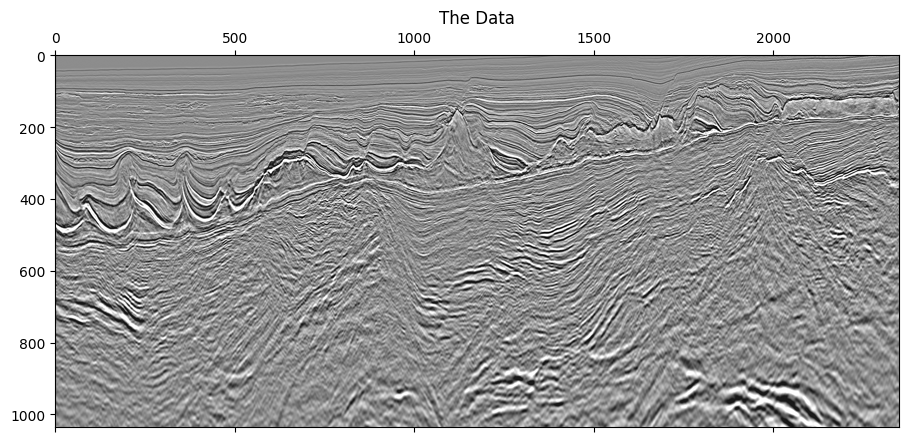

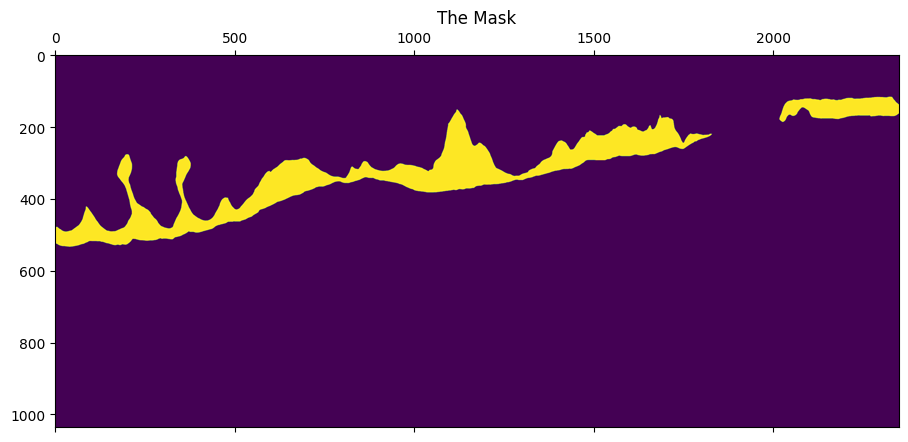

In [25]:
# Load the seismic image data as NumPy array
data = mpimg.imread('seismic_deep_learning/tutorial-01/seismic.tif')

# Kepp only the first channel
data = data[:, :, : 1] / 255

# Load mask image
mask = mpimg.imread('seismic_deep_learning/tutorial-01/mask.tif').copy() # to copy the dimension as the data before

# Normalize the values to just 0 -> 1
mask = (mask - mask.min()) / (mask.max() - mask.min())

# visualize data we're working on
plt.matshow(data[:, :, 0], interpolation='spline16', cmap=plt.cm.gray, aspect =1)
plt.title("The Data")
plt.show()

# Visualize the mask
plt.matshow(mask, interpolation='spline16', aspect=1)
plt.title("The Mask")
plt.show()


In [26]:
# Same as before, since we dont have a lot of mask image, we can use small size image (patches) to train the model
num_patch = 10000
patch_size = 128 # width and height of each square patch
val_split = 0.2 # Fraction of data reserved for validation

# Now we make function to extract random patches from the input data and corresponding mask
def extract_patches(data, mask, num_patch, patch_size):

  # Initialize empty array to hold input (X) and target (Y)
  # Shape: (num of patches, height, width, 1 channel)
  X = np.empty((num_patch, patch_size, patch_size, 1))
  Y = np.empty((num_patch, patch_size, patch_size, 1))

  # Get the dimension of the input data
  (t_max, x_max, _) = data.shape

  for n in range(num_patch):

    # Select random central point for patch
    # Make sure its far enough from edges
    x_n = random.randint(patch_size // 2, x_max - patch_size // 2)
    t_n = random.randint(patch_size // 2, t_max - patch_size // 2)

    # Extract the patch centered at (t_n, x_n) from the data and mask
    # Add a single channel dimension for compatibility with CNN
    X[n, :, :, 0] = data[t_n - patch_size // 2:t_n + patch_size // 2,
                         x_n - patch_size // 2:x_n + patch_size // 2,0]
    Y[n, : , :, 0] = mask[t_n - patch_size // 2:t_n + patch_size // 2,
                         x_n - patch_size // 2:x_n + patch_size // 2]

  return X, Y

# Extract training patches from the left half of image (0 to 1500 in x direction)
X_train, Y_train = extract_patches(data[:,:1500], mask[:, :1500],
                                   int(num_patch * (1 - val_split)), patch_size )

# Now extect validation patches from right half of the image
X_val, Y_val = extract_patches(data[:, 1500:], mask[:, 1500:],
                               int(num_patch * val_split), patch_size)

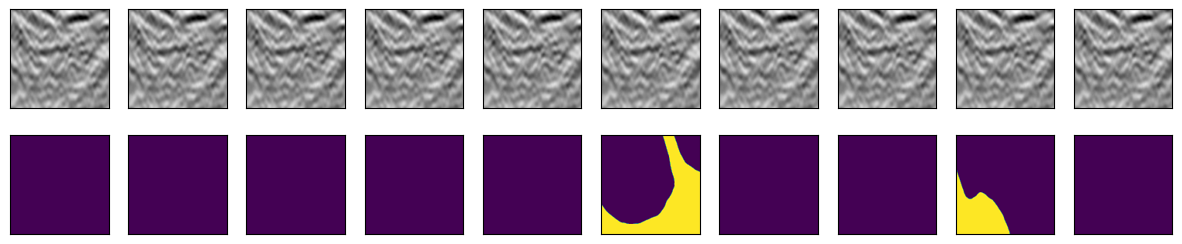

In [27]:
# Visualize our test data and validation data

# The size 15 inches wide and 3 inches tall
fig, axs =plt.subplots(2, 10, figsize=(15,3))

k = 0 # Patch index to visualize

# Plot for training (just 10)
for m in range(10):
  axs[0, m].imshow(X_train[k, :, :, 0],       # Display the k-th number input patch
                   interpolation = 'spline16', # Smooth interpolation for better visual
                   cmap = plt.cm.gray, # Use grayscale
                   aspect=1) # Keep aspect ration square
  axs[0, m].set_xticks([]) # Remove x-axis ticks
  axs[0,m].set_yticks([]) # Remove y-axis ticks

k = 0 # reset the patch index

for m in range(10):
  axs[1, m].imshow(Y_train[k, :, :, 0],
                   interpolation = 'spline16',
                   aspect = 1)
  axs[1, m].set_xticks([])
  axs[1,m].set_yticks([])

  k += 1

# 2. Now we already load in the data, make it to patches, and assign which one is the for the training and which one is for validation, we can move on to make the model and train it

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

  # Make the model architecture
class Downblock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 3, padding = 1, stride = 1):
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image.
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size, padding = padding, stride = stride)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = kernel_size, padding = padding, stride = stride)
        self.relu2 = nn.ReLU()

        # Downsampling use max pool
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)


    def forward(self, x):
      c = self.relu1(self.conv1(x))
      c = self.relu2(self.conv2(c))
      p = self.maxpool(c)

      return c,p # Return both conv output (for skip connection) and the pooled output

class Upblock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size = 3, padding = 1, stride = 1):
      super().__init__()

      self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

      # Decoder
      self.conv1 = nn.Conv2d(in_channels + out_channels, out_channels, kernel_size, padding = padding, stride = stride)
      self.relu1 = nn.ReLU()
      self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding, stride = stride)
      self.relu2 = nn.ReLU()

  def forward (self, x, skip):
    upsample = self.upsample(x)
    # Now we need to concat (make connection chain like)
    target_size = skip.shape[-2:]
    current_size = upsample.shape[-2:]
    # It will be crucial for U-Net, sometimes need to crop the skip
    if upsample.shape[-2:] != skip.shape[-2:]:
      diffy = skip.size()[2] - upsample.size()[2]
      diffx = skip.size()[3] - upsample.size()[3]
      upsample = F.pad(upsample, [diffx // 2, diffx - diffx // 2,
                                diffy // 2, diffy - diffy // 2])


    concat = torch.cat([upsample, skip], dim=1) # Concatenate along the channel dimension
    c = self.relu1(self.conv1(concat))
    c = self.relu2(self.conv2(c))
    return c


# Bottleneck (deepest) part of U-Net
class Bottleneck(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size = 3, padding = 1, stride = 1):
    super().__init__()
    # Two convolutional layer without downsampling
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding = padding, stride = stride)
    self.relu1 = nn.ReLU(inplace = True)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding = padding, stride = stride)
    self.relu2 = nn.ReLU(inplace = True)

  def forward(self,x):
    c = self.relu1(self.conv1(x))
    c = self.relu2(self.conv2(c))
    return c


# Define the full U-Net architecture
class UNet(nn.Module):
  def __init__(self, patch_size, in_channels = 1, out_channels = 1):
    super().__init__()
    self.f = [16,32,64,128, 256]

    # Encoder path
    self.down1 = Downblock(in_channels, self.f[0])
    self.down2 = Downblock(self.f[0], self.f[1])
    self.down3 = Downblock (self.f[1], self.f[2])
    self.down4 = Downblock (self.f[2], self.f[3])

    # Bottlenect (lowest resolution, most abstract features)
    self.Bottleneck = Bottleneck(self.f[3], self.f[4])

    # Decoder path
    # Note: The in_channels for UpBlock's first conv layer will be (current_level_filters + skip_connection_filters)
    # The skip_connection_filters come from the corresponding down_block's output `c`.
    # So, for u1, it's (bottleneck_filters + c4_filters) -> f[4] + f[3]
    self.up1 = Upblock(self.f[4], self.f[3])
    self.up2 = Upblock(self.f[3], self.f[2])
    self.up3 = Upblock(self.f[2], self.f[1])
    self.up4 = Upblock(self.f[1], self.f[0])

    self.final_conv = nn.Conv2d(self.f[0], 1, kernel_size=1)
    self.sigmoid = nn.Sigmoid()

  def forward (self,x):
    # Encoder
    c1, p1 = self.down1(x)
    c2, p2 = self.down2(p1)
    c3, p3 = self.down3(p2)
    c4, p4 = self.down4(p3)

    # Bottleneck
    bn = self.Bottleneck(p4)

    # Decoder
    u1 = self.up1(bn, c4)
    u2 = self.up2(bn, c3)
    u3 = self.up3(bn, c2)
    u4 = self.up4(bn, c1)

    # Output
    outputs = self.sigmoid(self.final_conv(u4))
    return outputs

patch_size = 128
model = UNet(patch_size=patch_size, in_channels=1, out_channels=1)


# To print the model summary (similar to model.summary() in Keras)
# from torchsummary import summary
# summary(model, (1, patch_size, patch_size)) # (channels, height, width)

# Instantiate and configure the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Learning rate can be tuned
loss_fn = nn.BCELoss()

In [35]:
from torch.utils.data import Dataset, DataLoader, random_split
class SeismicDataset(Dataset):
    def __init__(self, X_data, Y_data):
        # PyTorch expects channel-first (N, C, H, W)
        # Your NumPy arrays are (N, H, W, C), so permute dimensions
        self.X = torch.from_numpy(X_data).permute(0, 3, 1, 2)
        self.Y = torch.from_numpy(Y_data).permute(0, 3, 1, 2)
        # Ensure data types are float32
        self.X = self.X.float()
        self.Y = self.Y.float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Create dataset instances
train_dataset = SeismicDataset(X_train, Y_train)
val_dataset = SeismicDataset(X_val, Y_val)

# Create DataLoader instances
BATCH_SIZE = 16 # You can adjust this
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) # No need to shuffle validation data


In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [37]:
# Create train, test functions and the real training part

# Train step
def train_step(model : torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  # Put the model in training mode
  model.train()

  # Setup train loss and train accuracy initial values
  train_loss, train_accuracy = 0, 0

  # Loop through data loader and data batches
  for batch, (X,y) in enumerate(data_loader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimzer step
    optimizer.step()

    # Calculate and accumulate accuracy metric accross all batches
    y_pred_class = (y_pred > 0.5).float()
    train_accuracy += (y_pred_class == y).sum().item() / torch.numel(y)

  # Adjust metrics to get average loss and average accuracy per batch
  return train_loss / len(data_loader), train_accuracy / len(data_loader)


# Test step
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
  test_loss, test_acc = 0, 0

  model.eval()

  # Use inference mode
  with torch.inference_mode():
    for batch, (X,y) in enumerate(data_loader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass (output raw logits)
      test_pred_logits = model(X)

      # 2. Calculate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # 3. Calculate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

    # Calculate the test loss average per batch
    test_loss /= len(data_loader)

    # Calculate the test loss average per batch
    test_acc /= len(data_loader)

  # Print out
  print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")
  return test_loss, test_acc

# The real training step that combine 2 above
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          device = device):
  results = {
      "train_loss" : [],
      "train_accuracy": [],
      "test_loss": [],
      "test_acc": []
  }

  for epoch in range(epochs):
    train_loss, train_accuracy = train_step(
        model = model,
        data_loader = train_dataloader,
        loss_fn=loss_fn,
        optimizer = optimizer,
        device = device
    )
    test_loss, test_acc = test_step(
        model = model,
        data_loader = test_dataloader,
        loss_fn = loss_fn,
        device = device
    )

    print(f"Epoch {epoch+1}: "
          f"Train loss: {train_loss:.4f} | Train acc: {train_accuracy:.4f} | "
          f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_accuracy"].append(train_accuracy)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [39]:
# Train for 5 epoch
NUM_EPOCHS = 5

# Recreate an instance of UNet
# FIX: Correct UNet initialization arguments
model_0 = UNet(patch_size=patch_size, in_channels=1, out_channels=1).to(device)

# Re-define optimizer to use the parameters of the newly instantiated model_0
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_timer = timer()

# Train model_0
model_0_results = train(model = model_0,
                        train_dataloader = train_dataloader,
                        test_dataloader = val_dataloader,
                        optimizer = optimizer,
                        loss_fn=loss_fn,
                        epochs = NUM_EPOCHS)

# End the timer and print out how long
end_timer = timer()
print(f"Total training time: {end_timer - start_timer:.3f} seconds")

RuntimeError: Given groups=1, weight of size [64, 192, 3, 3], expected input[16, 320, 32, 32] to have 192 channels, but got 320 channels instead

In [ ]:
# Optional: Plotting results
def plot_loss_curves(results):
    """Plots training curves of a results dictionary."""
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_accuracy"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

# plot_loss_curves(model_0_results)